There are lots of applications of text classification in the commercial world. For example, news stories are typically organized by topics; content or products are often tagged by categories; users can be classified into cohorts based on how they talk about a product or brand online …  

However, the vast majority of text classification articles and tutorials on the internet are **binary text classification** such as email spam filtering (spam vs. ham), sentiment analysis (positive vs. negative). In most cases, our real world problem are much more complicated than that. Therefore, this is what we are going to do today: *Classifying Consumer Finance Complaints into 18 pre-defined classes*. The data can be downloaded from [data.gov](https://catalog.data.gov/dataset/consumer-complaint-database).  

## Aim
The problem is supervised text classification problem, and our goal is to investigate which supervised machine learning methods are best suited to solve it.  

Given a new complaint comes in, we want to assign it to one of 18 categories. The classifier makes the assumption that each new complaint is assigned to one and only one category. This is multi-class text classification problem.  


## Data

- Input: 'Consumer complaint narrative'
- Output: 'product'

## Ref
- `sklearn.feature_selection.chi2` computes chi-squared stats between each non-negative feature and class. This score can be used to select the n_features features with the highest values for the test chi-squared statistic from X, which must contain only non-negative features such as booleans or frequencies (e.g., term counts in document classification), relative to the classes. https://www.lizenghai.com/archives/34278.html 
- `numpy.argsort` returns the indices that would sort an array.
- `sklearn.model_selection.cross_val_score` evaluates a score by cross-validation. 
- `sklearn.metrics.classification_report` builds a text report showing the main classification metrics. Text summary of the precision, recall, F1 score for each class.

## 0. Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

## 1. Import the Dataset

In [2]:
df = pd.read_csv('data/complaints.csv', index_col=False, delimiter=',', encoding='utf-8')

## 2. Preview the Dataset

In [3]:
# Display the dimensions of the dataset.
rows = df.shape[0]
columns = df.shape[1]
feature_set = df.columns.values
print('Total Number of Features: ', columns)
print('Total Number of Instances: ', rows)
print('Feature Set includes: ', feature_set) 

Total Number of Features:  18
Total Number of Instances:  1523040
Feature Set includes:  ['Date received' 'Product' 'Sub-product' 'Issue' 'Sub-issue'
 'Consumer complaint narrative' 'Company public response' 'Company'
 'State' 'ZIP code' 'Tags' 'Consumer consent provided?' 'Submitted via'
 'Date sent to company' 'Company response to consumer' 'Timely response?'
 'Consumer disputed?' 'Complaint ID']


In [4]:
# Preview the first 5 instances.
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
4,2019-02-08,Vehicle loan or lease,Lease,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,HYUNDAI CAPITAL AMERICA,FL,33161,NaN,Consent not provided,Web,2019-02-08,Closed with non-monetary relief,Yes,NaN,3146310


In [5]:
# Display the dimensions and data type of the train data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1523040 entries, 0 to 1523039
Data columns (total 18 columns):
Date received                   1523040 non-null object
Product                         1523040 non-null object
Sub-product                     1287875 non-null object
Issue                           1523040 non-null object
Sub-issue                       962452 non-null object
Consumer complaint narrative    501412 non-null object
Company public response         574853 non-null object
Company                         1523040 non-null object
State                           1497351 non-null object
ZIP code                        1379636 non-null object
Tags                            207055 non-null object
Consumer consent provided?      902220 non-null object
Submitted via                   1523040 non-null object
Date sent to company            1523040 non-null object
Company response to consumer    1523039 non-null object
Timely response?                1523040 non-null obj

In [6]:
# Return the statistics for all numeric variables.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Complaint ID,1523040.0,2.160499e+06,1.033462e+06,1.0,1326203.75,2430408.5,3040612.25,3557522.0


## 3. Exploratory Data Analysis (EDA)

For this project, we need only two columns — “Product” and “Consumer complaint narrative”. 

We will remove missing values in “Consumer complaints narrative” column, and add a column encoding the product as an integer because categorical variables are often better represented by integers than strings.

In [7]:
df = df[['Product', 'Consumer complaint narrative']]                                              # only keep two columns
df.dropna(subset=['Consumer complaint narrative'], inplace=True)                                  # drop nan rows
df.rename(columns={'Consumer complaint narrative':'Consumer_complaint_narrative'}, inplace=True)  # rename column name

In [8]:
codes, uniques = pd.factorize(df['Product'])  # Encode the string as an enumerated type
df['category_id'] = codes                     # Add new column
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')  
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df.head()

,Product,Consumer_complaint_narrative,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,1
3,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
10,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh...",2
11,Debt collection,While checking my credit report I noticed thre...,0


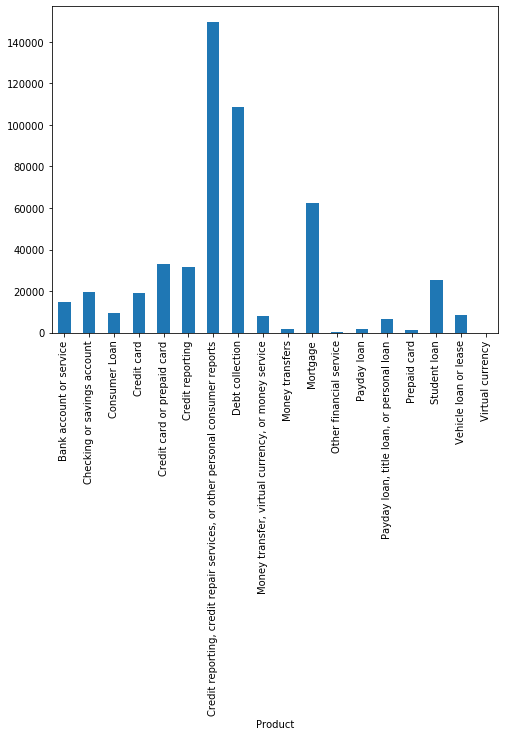

In [9]:
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

We see that the number of complaints per product is imbalanced. Consumers’ complaints are more biased towards Debt collection, Credit reporting and Mortgage.

When we encounter such problems, we are bound to have difficulties solving them with standard algorithms. Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. For some cases, such as fraud detection or cancer prediction, we would need to carefully configure our model or artificially balance the dataset, for example by [undersampling or oversampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) each class.

However, in our case of learning imbalanced data, the majority classes might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes. Therefore, we will leave it as it is.

## 4. Feature Engineering

The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, during the preprocessing step, the texts are converted to a more manageable representation.

One common approach for extracting features from text is to use the bag of words model: a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.


### 4.1 Extract Features via TF-IDF

Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. We will use `sklearn.feature_extraction.text.TfidfVectorizer` to calculate a tf-idf vector for each of consumer complaint narratives:

In [11]:
# sublinear_df is set to True to use a logarithmic form for frequency.
# min_df is the minimum numbers of documents a word must be present in to be kept.
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id

print(features.shape)

(501412, 881075)


Now, each of 501412 consumer complaint narratives is represented by 881075 features, representing the tf-idf score for different unigrams and bigrams.

### 4.2 Find the most correlated feature for each product

We can use `sklearn.feature_selection.chi2` to find the terms that are the most correlated with each of the products:

In [14]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels==category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
       . bank
       . overdraft
  . Most correlated bigrams:
       . overdraft fees
       . checking account
# 'Checking or savings account':
  . Most correlated unigrams:
       . overdraft
       . deposit
  . Most correlated bigrams:
       . savings account
       . checking account
# 'Consumer Loan':
  . Most correlated unigrams:
       . car
       . vehicle
  . Most correlated bigrams:
       . chrysler capital
       . auto loan
# 'Credit card':
  . Most correlated unigrams:
       . macy
       . card
  . Most correlated bigrams:
       . american express
       . credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
       . express
       . card
  . Most correlated bigrams:
       . american express
       . credit card
# 'Credit reporting':
  . Most correlated unigrams:
       . experian
       . equifax
  . Most correlated bigrams:
       . manner soon
       . disputed resolve
# 'Credit rep

## 5. Define the model

We are now ready to experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.  

We will benchmark the following four models:  

- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

In [17]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=1, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)
]

In [ ]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models))) # 4*5=20 rows
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV) # Evaluate a score by cross-validation
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.head()

In [ ]:
cv_df.groupby('model_name').accuracy.mean() # Calculate the average accuracy for each model

In [ ]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

LinearSVC and Logistic Regression perform better than the other two classifiers, with LinearSVC having a slight advantage with a median accuracy of around 82%.

## 6. Evaluate the model

Continue with our best model (LinearSVC), we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

In [ ]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. However, there are a number of misclassifications, and it might be interesting to see what those are caused by:

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

As you can see, some of the misclassified complaints are complaints that touch on more than one subjects (for example, complaints involving both credit card and credit report). This sort of errors will always happen.

Again, we use the chi-squared test to find the terms that are the most correlated with each of the categories:

In [ ]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

They are consistent within our expectation.

Finally, we print out the classification report for each class:

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))